Modified from polychrom extrusion_1D_newCode\
Original Source : https://github.com/open2c/polychrom.git \
Licensed under MIT License\
Copyright (c) 2019 Massachusetts Institute of Technology

for Linear Polymer

In [4]:
from lef_sim import translocate, loadOne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py 
import os 

In [5]:
foldername = "trajectory_20260224_1"
h5_filepath = f"{foldername}/LEFPositions_big.h5"

In [19]:
#parameters
N = 50000 #length of a polymer (chromosome)
LIFETIME = 200
SEPARATION = 1000 #average distance of cohesins
LEFNum = N//SEPARATION #total cohesin number
trajectoryLength = 10000 #how long you want to simulate

ctcf_locations = [1000, 2000, 3500, 7000, 15000, 35000, 42000, 48000] #you can choose

In [20]:
args = {
    "N": N,
    "LIFETIME": LIFETIME,
    "LIFETIME_STALLED": 10,
    "ctcfCapture": {-1: {}, 1: {}},
    "ctcfRelease": {-1: {}, 1: {}}
}

# CTCF dictionary
for loc in ctcf_locations:
    args["ctcfCapture"][-1][loc] = 0.5  # left leg capture prob
    args["ctcfCapture"][1][loc] = 0.5   # right leg capture prob
    args["ctcfRelease"][-1][loc] = 0.02 # left leg release prob
    args["ctcfRelease"][1][loc] = 0.02  # right leg release prob

#initialization
occupied = np.zeros(N)
# 시스템의 맨 처음과 끝만 벽으로 막음 (하나의 거대한 시스템이므로)
occupied[0] = 1
occupied[N-1] = 1

cohesins = []
for i in range(LEFNum):
    loadOne(cohesins, occupied, args)

folder = foldername
if not os.path.exists(folder):
    os.makedirs(folder)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

with h5py.File(h5_filepath, mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")

    save_steps = 50 
    bins = np.linspace(0, trajectoryLength, save_steps + 1, dtype=int)
    
    for st, end in zip(bins[:-1], bins[1:]):
        cur = np.zeros((end - st, LEFNum, 2), dtype=np.int32)
        for i in range(st, end):
            translocate(cohesins, occupied, args)
            for j in range(min(len(cohesins), LEFNum)):
                cur[i - st, j, 0] = cohesins[j].left.pos
                cur[i - st, j, 1] = cohesins[j].right.pos
        
        dset[st:end] = cur
        
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum

print(f"Finished! {N} length one polymer simulation created.")

Finished! 50000 length one polymer simulation created.


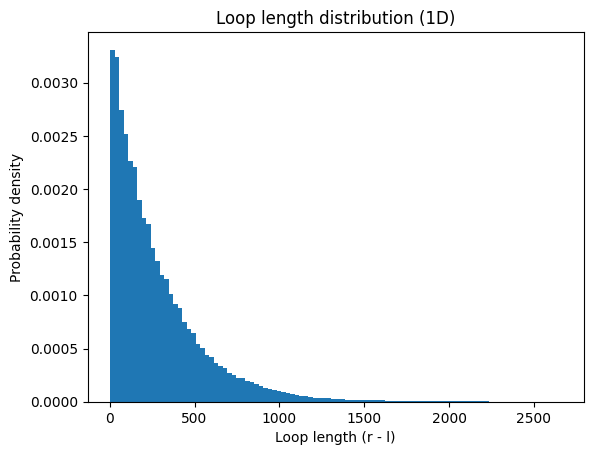

In [21]:
with h5py.File(h5_filepath, "r") as f:
    positions = f["positions"][:]

loop_lengths = positions[:,:,1] - positions[:,:,0]
loop_lengths = loop_lengths.flatten()

plt.hist(loop_lengths, bins=100, density=True)
plt.xlabel("Loop length (r - l)")
plt.ylabel("Probability density")
plt.title("Loop length distribution (1D)")
plt.show()

#loop length = | r - l |

Hi-C Map for 1D Loop

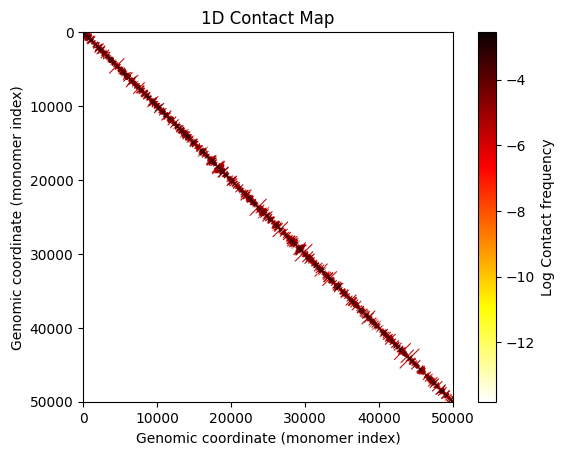

In [30]:
steps = 10
#make the contact map

bin_size = 100

with h5py.File(h5_filepath, "r") as f:
    positions = f["positions"][:]
    N = f.attrs["N"]

cmap = np.zeros((N, N), dtype=np.float32)

for t in range(0, len(positions), steps):
    for l, r in positions[t]:
        cmap[l, r] += 1
        cmap[r, l] += 1
#contact of left & right --> contact! (we somehow ignored the loop between r and l)

#update the Hi-C contact map

cmap /= (len(positions) / steps)

Nb = N // bin_size
cmap_binned = cmap.reshape(Nb, bin_size, Nb, bin_size).sum(axis=(1,3))

extent = [0, N, N, 0]

plt.figure()

res = np.log(cmap_binned+1e-6)

plt.imshow(res,
           cmap="hot_r",
           extent=extent,
          )
plt.title("1D Contact Map")
plt.xlabel("Genomic coordinate (monomer index)")
plt.ylabel("Genomic coordinate (monomer index)")
plt.colorbar(label="Log Contact frequency")

plt.show()

In [31]:
N1 = 5000

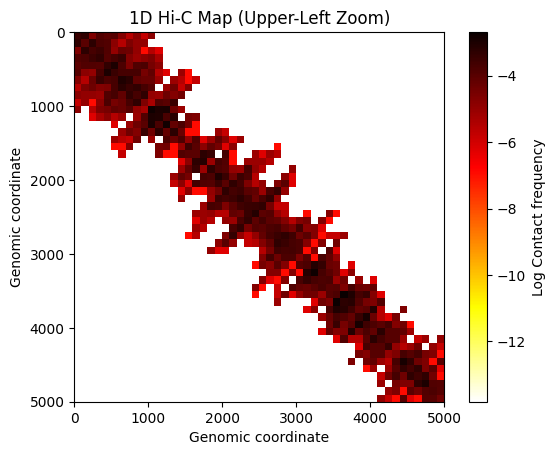

In [32]:
res_sub = res[:int(N1/bin_size), :int(N1/bin_size)]

view_limit_genomic = N1
extent_sub = [0, view_limit_genomic, view_limit_genomic, 0]

plt.figure()

plt.imshow(res_sub,
           cmap="hot_r",
           extent=extent_sub,
          )

plt.title("1D Hi-C Map (Upper-Left Zoom)")
plt.xlabel("Genomic coordinate")
plt.ylabel("Genomic coordinate")
plt.colorbar(label="Log Contact frequency")

plt.show()